# OECD data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#SSL-issues" data-toc-modified-id="SSL-issues-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SSL issues</a></span></li></ul></li><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#OECD-support" data-toc-modified-id="OECD-support-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OECD support</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Python-functions" data-toc-modified-id="Python-functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Python functions</a></span></li></ul></li><li><span><a href="#OECD-GDP-data" data-toc-modified-id="OECD-GDP-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>OECD GDP data</a></span><ul class="toc-item"><li><span><a href="#Real-GDP-growth" data-toc-modified-id="Real-GDP-growth-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Real GDP growth</a></span></li><li><span><a href="#Nominal-GDP---national-currency" data-toc-modified-id="Nominal-GDP---national-currency-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Nominal GDP - national currency</a></span></li><li><span><a href="#National-saving" data-toc-modified-id="National-saving-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>National saving</a></span></li></ul></li><li><span><a href="#OECD-inflation-data" data-toc-modified-id="OECD-inflation-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>OECD inflation data</a></span><ul class="toc-item"><li><span><a href="#Headline-inflation---selected-nations" data-toc-modified-id="Headline-inflation---selected-nations-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Headline inflation - selected nations</a></span></li><li><span><a href="#Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)" data-toc-modified-id="Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Annualised and quarterly smoothed (using seasonally adjusted series)</a></span></li><li><span><a href="#Latest-CPI-components" data-toc-modified-id="Latest-CPI-components-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Latest CPI components</a></span></li></ul></li><li><span><a href="#Real-interest-rates" data-toc-modified-id="Real-interest-rates-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Real interest rates</a></span><ul class="toc-item"><li><span><a href="#Get-Bank-for-International-Settlements-(BIS)-Data" data-toc-modified-id="Get-Bank-for-International-Settlements-(BIS)-Data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Get Bank for International Settlements (BIS) Data</a></span></li><li><span><a href="#Notional-real-interest-rates" data-toc-modified-id="Notional-real-interest-rates-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Notional real interest rates</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Notes

### SSL issues

From January 2023 I got the error message: SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED. 
I gather the immediate issue is changes to the openSSL library. But the more significant issue is with the OECD website.

To fix this issue, I:

* created a text file named ~/ssl.conf with the following content:

        openssl_conf = openssl_init
    
        [openssl_init]
        ssl_conf = ssl_sect
    
        [ssl_sect]
        system_default = system_default_sect

        [system_default_sect]
        Options = UnsafeLegacyRenegotiation

* added this line to my .zshrc file (because I use zsh as my shell): 

        export OPENSSL_CONF=~/ssl.conf

## Python setup

### Imports

In [1]:
# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import seaborn as sns
from pandasdmx import Request
from requests.exceptions import HTTPError

# system imports
from pathlib import Path
from datetime import date

# local imports
from finalise_plot import finalise_plot
from rba_common import plot_series_highlighted
from common import get_bis_cbpr

### Settings

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# multi-time-period charts
TODAY = pd.Timestamp('today')
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)
MONTH_ADJ = 2 # months
RECENT = RECENT - pd.DateOffset(months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./charts/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

## OECD support

### Data

In [3]:
location_map = {
    'AUS':	'Australia',
    'AUT':	'Austria',
    'BEL':	'Belgium',
    'CAN':	'Canada',
    'CHL':	'Chile',
    'CZE':	'Czech Rep.',
    'DNK':	'Denmark',
    'EST':	'Estonia',
    'FIN':	'Finland',
    'FRA':	'France',
    'DEU':	'Germany',
    'GRC':	'Greece',
    'HUN':	'Hungary',
    'ISL':	'Iceland',
    'IRL':	'Ireland',
    'ISR':	'Israel',
    'ITA':	'Italy',
    'JPN':	'Japan', 
    'KOR':	'Korea',
    'LVA':	'Latvia',
    'LUX':	'Luxembourg',
    'MEX':	'Mexico',
    'NLD':	'Netherlands',
    'NZL':	'New Zealand',
    'NOR':	'Norway',
    'POL':	'Poland',
    'PRT':	'Portugal',
    'SVK':	'Slovak Rep.',
    'SVN':	'Slovenia',
    'ESP':	'Spain',
    'SWE':	'Sweden',
    'CHE':	'Switzerland',
    'TUR':	'Turkey',
    'GBR':	'United Kingdom',
    'USA':	'United States',
    'ARG':	'Argentina',
    'BRA':	'Brazil',
    'CHN':	'China',
    'COL':	'Colombia',
    'CRI':	'Costa Rica', 
    'IND':	'India',
    'IDN':	'Indonesia',
    'LTU':	'Lithuania',
    'RUS':	'Russia',
    'SAU':	'Saudi Arabia',
    'ZAF':	'South Africa',
}

In [4]:
chart_sets = {
    # Limit charts to 6 nations - otherwise they are too cluttered
    'of_interest': ['AUS', 'USA', 'CAN', 'DEU', 'GBR', 'JPN', ],
    'anglosphere': ['AUS', 'USA', 'CAN', 'NZL', 'GBR', 'IRL', ],
    'major_europe': ['FRA', 'DEU', 'ITA', 'GBR', 'RUS', 'ESP', ],
    'largest_economies': ['USA', 'CHN', 'JPN', 'DEU', 'GBR', 'IND', ],
    
    'asia': ['KOR', 'JPN', 'CHN', 'IND', 'IDN', ],
    'north_europe': ['DNK', 'SWE', 'NOR', 'ISL', 'FIN', 'GBR', ],
    'baltic_europe': ['LVA', 'LTU', 'EST', ],
    'central_europe': ['CZE', 'HUN', 'SVK', 'SVN', 'POL', 'GRC', ],
    'west_europe': ['ESP', 'PRT', 'NLD', 'LUX', 'FRA', 'BEL', ],
    'italo_germanic_europe': ['DEU', 'AUT', 'CHE', 'ITA', ],
    'turkey': ['TUR', ], # a high inflation outlier.
   
    'n_america': ['USA', 'CAN', 'MEX', ],
    'c_s_america': ['CHL', 'ARG', 'BRA', 'COL', 'CRI', ],

    'other': ['AUS', 'NZL', 'SAU', 'ZAF', 'ISR', ],
}

### Python functions

In [5]:
def build_key(locations, subject, measure, frequency, start):
    if frequency:
        key = [locations, subject, measure, frequency]
    else:
        key = [locations, subject, measure]    
    key_string = (
        f"{'.'.join(['+'.join(x) for x in key])}"
        f"/all?startTime={start}"
    )
    return key_string

In [6]:
# get the raw index data
def get_oecd_data(resource_id, key_string):
    oecd = Request('OECD')

    try:
        data = oecd.data(
            resource_id=resource_id,
            key=key_string,
        ).to_pandas()

    except HTTPError as err:
        data = pd.DataFrame()
          
    return data

In [7]:
# download the CPI data
def download_CPI_data(locations=location_map,
                      start='1969', 
                      subject_tuple=('CP18ALTT', 'CPALTT01'), 
                      measure='IXOB'):

    combined = pd.DataFrame()
    
    q_locations = {'AUS', 'NZL', }
    monthly = [x for x in locations if x not in q_locations]
    quarterly = [x for x in locations if x in q_locations]

    for locations, freq in zip((monthly, quarterly), ('M', 'Q')):
        for subject in subject_tuple:
            if not len(locations):
                continue
            key = build_key(locations, [subject], [measure], freq, start)
            data = get_oecd_data(resource_id='PRICES_CPI', key_string=key)
            if not len(data):
                continue
            data = data.unstack().T.droplevel(axis=1, level=[1, 2, 3])
            data.index = pd.PeriodIndex(data.index, freq=freq)
            if freq == 'Q':
                data = data.resample('M', convention='end').sum()
            combined = (
                data if not len(combined) 
                else pd.concat([combined, data], axis=1, join='outer')
            ).sort_index()
            locations = [x for x in locations if x not in data.columns]
            
    return combined

In [8]:
def download_qtrly_data(resource_id, key_string):
    data = (
        get_oecd_data(resource_id=resource_id, key_string=key)
        .unstack()
        .T
        .dropna(how='all', axis='rows')
        .droplevel(axis=1, level=[1, 2, 3])
    )
    data.index = pd.PeriodIndex(data.index, freq='Q')

    return data

## OECD GDP data

### Real GDP growth

In [9]:
# rGDP - get the data
resource_id = 'QNA' # Quarterly National Accounts
measure = 'VPVOBARSA' # US dollars, volume estimates, fixed PPPs, 
                      # OECD reference year, annual levels, 
                      # seasonally adjusted
subject =  'B1_GE'  # Gross domestic product - expenditure approach
rfooter = f'Source: OECD {resource_id} {subject} {measure}'
lfooter = 'Volume est., US$, fixed PPPs, Seas Adj'

key = build_key(location_map, [subject], [measure], ['Q'], '1959')
rgdp = download_qtrly_data(resource_id, key)
rgdp_growth = rgdp.pct_change(1, fill_method=None) * 100

In [10]:
# diagnostics
rgdp_growth.shape

(256, 45)

In [11]:
# check for missing data in the final period ...
final_row = rgdp.iloc[-1]
missing_count = final_row.isna().sum()
if missing_count:
    print(f'Final period: {final_row.name}')
    print(f'Missing data count for final period: {missing_count}')
    print(f'Missing data belongs to: {rgdp.columns[final_row.isna()].to_list()}')

Final period: 2022Q4
Missing data count for final period: 27
Missing data belongs to: ['ARG', 'AUS', 'BRA', 'CHE', 'CHL', 'COL', 'DNK', 'EST', 'FIN', 'GBR', 'GRC', 'HUN', 'IND', 'ISL', 'ISR', 'JPN', 'LUX', 'NLD', 'NOR', 'NZL', 'POL', 'RUS', 'SAU', 'SVK', 'SVN', 'TUR', 'ZAF']


In [12]:
# GDP identify/count quarterly contractions
contractions = rgdp_growth < 0
contraction_count = contractions.sum(axis=1)

start = pd.Period('1999Q1', freq='Q')
tag = ''
title = 'Num. OECD Monitored States with Qrtly GDP contraction'
ax = contraction_count[contraction_count.index >= start].plot.bar()
ax.set_xticks(ax.get_xticks()[::4])
finalise_plot(
    ax, title, 
    'Count', 
    tag, CHART_DIR,
    rfooter=rfooter,
    #show=True,
)

In [13]:
# List nations in contraction at last quarter
", ".join([location_map[x] for x in contractions.iloc[-1][contractions.iloc[-1]].index])

'Austria, Czech Rep., Germany, Italy, Korea, Lithuania, Sweden'

In [14]:
# GDP identify/count recessions
recession = (rgdp_growth < 0) & (rgdp_growth.shift(1) < 0)
recession_count = recession.sum(axis=1)

title = 'Number of OECD Monitored States in Recession'
ax = recession_count[recession_count.index >= start].plot.bar()
ax.set_xticks(ax.get_xticks()[::4])
finalise_plot(
    ax, title, 
    'Count', 
    tag, CHART_DIR,
    rfooter=rfooter,
    lfooter='Recession defined as two quarters of negative GDP growth',
    #show=True,
)

In [15]:
# List nations in recession at last quarter
", ".join([location_map[x] for x in recession.iloc[-1][recession.iloc[-1]].index])

'Czech Rep.'

In [16]:
# GDP growth plots
title = 'GDP Growth: quarter on quarter'
for label, locations in chart_sets.items(): 
    
    # get the data
    loc = [x for x in locations if x in rgdp_growth.columns]
    data = rgdp_growth[loc].rename(location_map, axis=1).sort_index(axis=1)

    # plot the data
    for start in None, RECENT:
        subset = (
            data if start is None 
            else data[data.index >= pd.Period(start, freq='Q')]
        )
        ax = subset.plot(lw=2.5)
        ax.legend(title=None, loc='best', ncol=2)
        tag = label if start is None else f'{label}-recent'

        finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=rfooter,
            lfooter=lfooter,
            zero_y=True,
            #show=True,
        )

### Nominal GDP - national currency

In [17]:
# nGDP - get the data
resource_id = 'QNA' # Quarterly National Accounts
measure = 'CQRSA' # National currency, current prices, quarterly levels
subject =  'B1_GE'  # Gross domestic product - expenditure approach
rfooter = f'Source: OECD {resource_id} {subject} {measure}'

key = build_key(location_map, [subject], [measure], ['Q'], '2000')
nGDP = download_qtrly_data(resource_id, key)
nGDP.tail()

LOCATION,ARG,AUS,AUT,BEL,BRA,CAN,CHE,CHL,COL,CRI,CZE,DEU,DNK,ESP,EST,FIN,FRA,GBR,GRC,HUN,IDN,IND,IRL,ISL,ISR,ITA,JPN,KOR,LTU,LUX,LVA,MEX,NLD,NOR,NZL,POL,PRT,RUS,SVK,SVN,SWE,TUR,USA,ZAF
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021Q4,13705955.8,564565.0,104209.5,130436.0,2286287.7,655544.0,187032.4,63898654.1,320301978.1,10510005.8,1552165.0,924492.0,660388.2,319346.0,8425.2,64965.0,641822.0,592735.0,47880.1,14634228.0,4498991.7,63349.4,110233.1,874756.6,417651.0,456435.8,137981825.0,530268900.0,14953.1,18938.9,8838.1,6619766.5,221144.6,1188449.0,89974.0,693611.5,55710.3,NaN,25395.6,13795.9,1421857.0,2196859.1,6087280.3,1571828.5
2022Q1,15773607.9,587494.0,107709.5,134678.0,2352016.9,680016.0,190104.1,64534431.2,339194744.5,10732506.2,1637620.0,944162.0,669828.2,320473.0,8731.5,65952.0,646619.4,606405.0,50095.6,15600075.0,4592686.2,64514.0,117872.8,899208.4,424519.0,462060.2,138227375.0,532765700.0,15672.0,19290.5,9395.3,6837603.8,227148.8,1333222.0,91247.0,731235.5,57807.4,NaN,25949.3,14131.3,1425202.0,2795247.3,6185120.0,1608257.2
2022Q2,18666804.9,611487.0,111447.4,137045.0,2472590.1,707531.0,191952.1,65668306.3,360302129.8,11026918.9,1678326.0,956203.0,700363.5,328938.0,8994.2,67769.0,654503.0,615994.0,51478.8,16345764.0,4890042.2,65443.8,124773.3,900460.8,436102.0,471420.1,139549025.0,540784300.0,16318.6,19698.0,9579.4,7077177.6,233203.6,1392781.0,94915.0,752015.0,59256.9,NaN,26643.4,14575.7,1477124.0,3547442.4,6312119.0,1652286.2
2022Q3,22433324.9,616437.0,114172.2,139705.0,2526788.0,702696.0,193953.7,66343076.5,369978476.8,11254069.0,1742535.0,969673.0,714224.6,334398.0,9155.8,68526.0,663940.7,626009.0,50408.8,17237348.0,4995205.6,66448.8,129100.5,959650.6,441995.0,473233.7,138531400.0,538803800.0,17179.2,20154.6,9867.5,7245146.9,238285.8,1566222.0,97599.0,765256.4,60199.1,NaN,27227.6,14961.9,1495063.0,4023176.4,6430985.3,1685115.2
2022Q4,NaN,NaN,113546.8,NaN,NaN,NaN,NaN,NaN,NaN,11232300.9,NaN,990373.0,NaN,345113.0,NaN,NaN,675144.0,NaN,NaN,NaN,5110511.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17619.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6533114.5,NaN


### National saving

In [18]:
# net savings - get the data
resource_id = 'QNA' # Quarterly National Accounts
measure = 'CQR' # National currency, current prices, quarterly levels
subject =  'B8NS1'  # Net saving

key = build_key(location_map, [subject], [measure], ['Q'], '2000')
net_saving = download_qtrly_data(resource_id, key)
net_saving.tail()

LOCATION,AUS,AUT,BEL,CAN,CRI,CZE,DEU,DNK,ESP,EST,FIN,FRA,GBR,GRC,HUN,IRL,ISR,ITA,LTU,LUX,LVA,NLD,POL,SVK,SVN,SWE,ZAF
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021Q4,55191.0,11170.9,NaN,57903.0,1157146.5,83027.0,102438.0,120737.0,27451.0,1194.3,4225.0,29470.7,14267.0,NaN,1712408.0,17468.7,81059.5,33479.8,1154.9,3638.8,448.5,19167.0,111740.0,-69.5,766.1,247022.0,NaN
2022Q1,32222.0,9038.4,11619.6,37070.0,993898.0,69063.0,99775.0,98087.0,8240.0,1246.0,3917.0,26267.9,17674.0,NaN,40352.0,13733.1,58465.3,6289.7,982.3,2766.7,-921.5,25907.0,45786.0,-1200.9,897.7,193327.0,NaN
2022Q2,53513.0,10280.0,11459.9,44055.0,945487.1,102944.0,58185.0,165821.0,17167.0,1517.7,680.0,47229.9,-3386.0,NaN,1650016.0,14159.6,62660.6,14208.8,1371.8,1839.3,66.9,21870.0,45377.0,-400.5,1320.3,239836.0,NaN
2022Q3,40293.0,10193.1,8619.4,78687.0,1071513.4,143157.0,72159.0,166972.0,17065.0,1763.3,4531.0,21644.5,-7967.0,NaN,2418384.0,21389.9,64972.0,7753.4,3376.8,772.9,-95.8,26732.0,74426.0,500.2,1279.8,172717.0,NaN
2022Q4,NaN,NaN,NaN,NaN,863532.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
start = pd.Period('2017Q1', freq='Q')
recent_net_savings = net_saving[net_saving.index > start]

lfooter = 'National currency, current prices, quarterly levels'
for col in recent_net_savings:
    ax = recent_net_savings[col].plot(lw=2.5)
    title = f'National Savings: {location_map[col]}'
    
    finalise_plot(
        ax, title, 
        'National Currency Units', 
        '', CHART_DIR,
        rfooter=rfooter,
        lfooter=lfooter,
        zero_y=True,
        #show=True,
    )

## OECD inflation data

### Headline inflation - selected nations

In [20]:
cpi = download_CPI_data()
#cpi.tail()

In [21]:
inflation = (
    cpi
    .pct_change(12, fill_method=None) # Note: default fill_method is nasty
    .interpolate(method='time', limit_area='inside') 
    * 100
)
#inflation.tail()

In [22]:
# plotting ...
title = 'CPI Growth: compared with same period in prev. year'
for label, locations in chart_sets.items(): 
    
    # get the data
    loc = [x for x in locations if x in inflation.columns]
    headline = inflation[loc].copy()
    headline = headline.rename(location_map, axis=1).sort_index(axis=1)

    # plot the data
    for start in None, RECENT:
        data = (
            headline if start is None 
            else headline[headline.index >= pd.Period(start, freq='M')]
        )
        ax = data.plot(lw=2.5)
        ax.axhspan(2, 3, color='#dddddd', label='2-3 per cent target', zorder=-1)
        ax.legend(title=None, loc='best', ncol=2)
        tag = label if start is None else f'{label}-recent'

        finalise_plot(
            ax, title, 
            'Per cent per year', 
            tag, CHART_DIR,
            rfooter=f'{SOURCE} CPI_PRICES',
            zero_y=True,
            #show=True,
        )

### Annualised and quarterly smoothed (using seasonally adjusted series)

In [23]:
def annualise_percentages(series:pd.Series, periods:int=12) -> pd.Series:
    """Annualise a growth rate for a period."""
    
    s = series / 100. 
    annual = (((1 + s) ** periods) - 1) * 100 
    return annual

In [24]:
locations = ['AUS', 'USA', 'CAN', 'DEU', 'JPN', ]
measure = 'IXOBSA'

cpi_sa = download_CPI_data(locations=locations,
                           start='1969',
                           measure=measure)

cpi_sa.tail(8)

LOCATION,JPN,CAN,DEU,USA,AUS
TIME_PERIOD,,,,,
2022-05,103.6396,119.5417,117.0707,122.9760,NaN
2022-06,103.8432,120.1738,116.8708,124.6020,117.1117
2022-07,104.2504,120.3318,117.4706,124.5780,NaN
2022-08,104.5559,120.4109,118.1705,124.7252,NaN
2022-09,104.9631,120.8849,120.6698,125.2066,119.3406
2022-10,105.3703,121.5960,121.8695,125.7555,NaN
2022-11,105.7775,121.9910,122.2694,125.8766,NaN
2022-12,106.0830,121.9120,120.7698,125.7766,121.4767


In [25]:
inflation_sa_a = annualise_percentages(
    series=
        cpi_sa
        .pct_change(3, fill_method=None) # Note: default fill_method is nasty
        .interpolate(method='time', limit_area='inside') 
        * 100 # per cent
    , periods=4)
inflation_sa_a.tail()

LOCATION,JPN,CAN,DEU,USA,AUS
TIME_PERIOD,,,,,
2022-08,3.583663,2.940317,3.811014,5.812112,7.653106
2022-09,4.384098,2.387997,13.650226,1.955072,7.833010
2022-10,4.366699,4.269070,15.841286,3.834706,7.673232
2022-11,4.756026,5.353254,14.613251,3.744046,7.513631
2022-12,4.336575,3.442165,0.331895,1.833463,7.354208


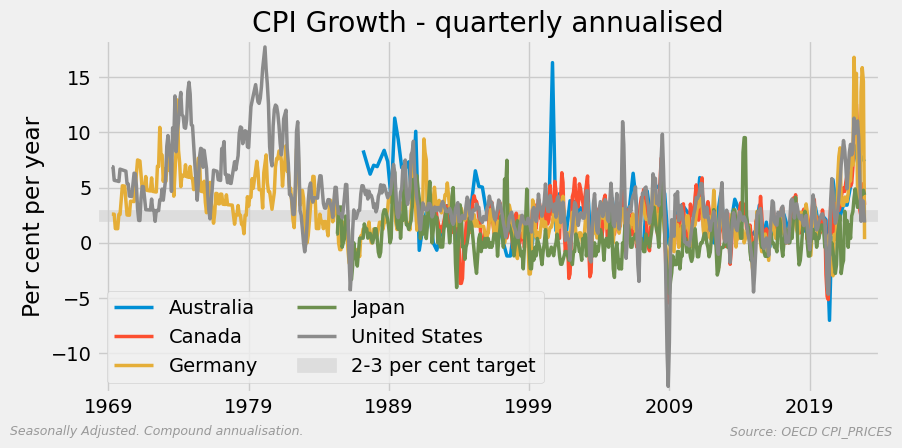

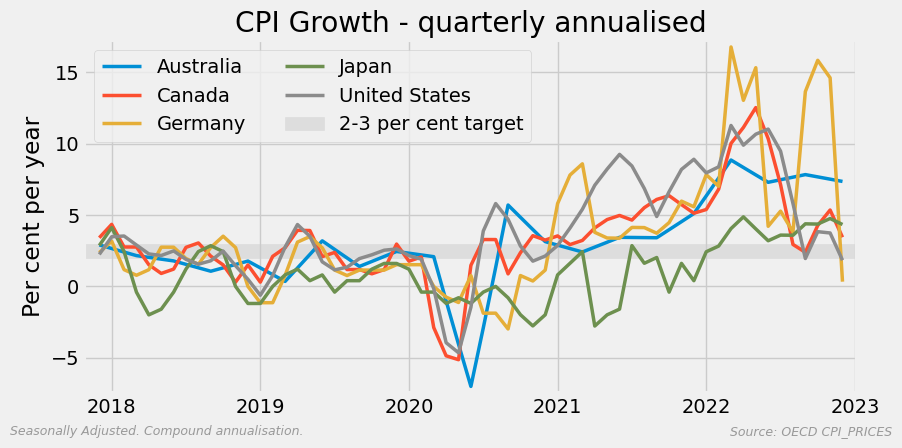

In [26]:
# plot 
title = 'CPI Growth - quarterly annualised'
for start in None, RECENT:
    data = (
        inflation_sa_a if start is None 
        else inflation_sa_a[inflation_sa_a.index >= pd.Period(start, freq='M')]
    )
    data = data.rename(location_map, axis=1).sort_index(axis=1)
    ax = data.plot(lw=2.5)
    ax.axhspan(2, 3, color='#dddddd', label='2-3 per cent target', zorder=-1)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES',
        lfooter='Seasonally Adjusted. Compound annualisation.',
        show=True,
)

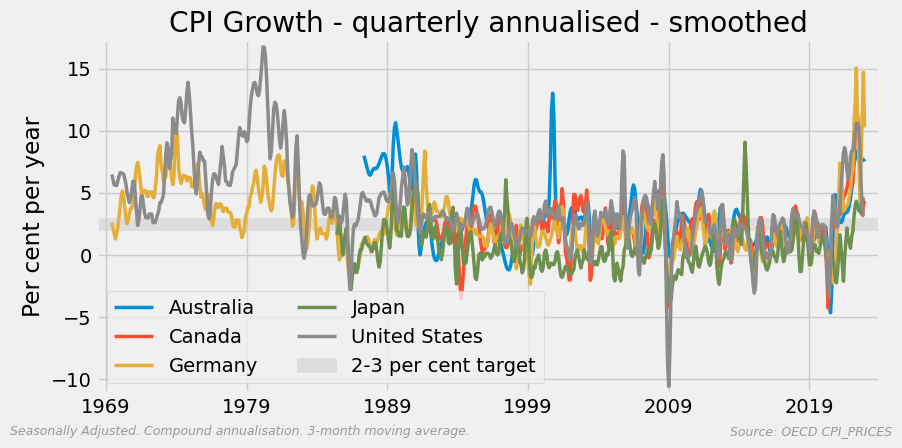

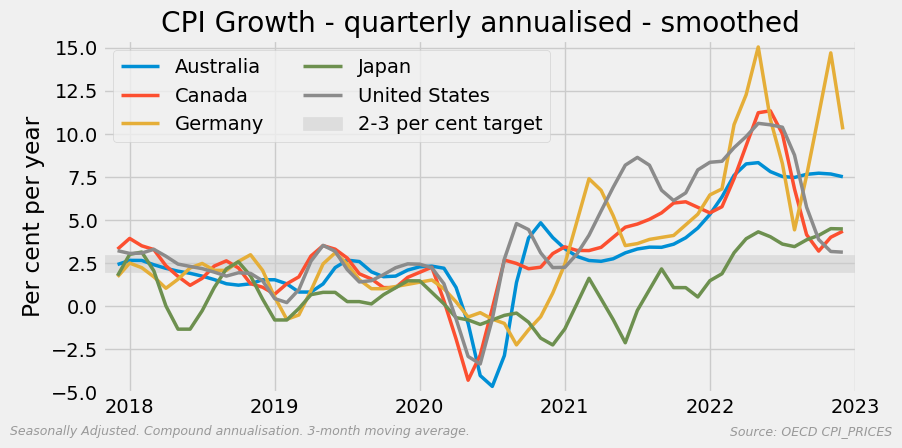

In [27]:
ma_period = 3 # months
inflation_sa_a_ma = inflation_sa_a.rolling(ma_period).mean()
# plot 
title = f'CPI Growth - quarterly annualised - smoothed'
for start in None, RECENT:
    data = (
        inflation_sa_a_ma if start is None 
        else inflation_sa_a_ma[inflation_sa_a_ma.index >= pd.Period(start, freq='M')]
    )
    data = data.rename(location_map, axis=1).sort_index(axis=1)
    ax = data.plot(lw=2.5)
    ax.axhspan(2, 3, color='#dddddd', label='2-3 per cent target', zorder=-1)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES',
        lfooter='Seasonally Adjusted. Compound annualisation. '
                f'{ma_period}-month moving average.',
        show=True,
)

### Latest CPI components

In [28]:
# set_up
all_items = ('CP18ALTT', 'CPALTT01')
food = ('CP180100', 'CP010000')
energy = ('CP18GREN', 'CPGREN01')
points = {
    'All items': all_items,
    'Food and non-alcoholic beverages': food,
    'Energy': energy,
}
locations = list(location_map.keys())
start = TODAY.year - 2
measure = 'IXOB'

In [29]:
frame = pd.DataFrame()
get_data_date = lambda series: str(pd.Period(series.last_valid_index(), freq='M'))
loop_count = 0

for component, subjects in points.items():
    cpi_x = download_CPI_data(start=start, subject_tuple=subjects)
    inf_x = (
        cpi_x
        .pct_change(12, fill_method=None) # Note: default fill_method is nasty
        * 100 # per cent
    )
    if not loop_count:
        latest_date = inf_x.apply(get_data_date)
        renamer = {x: f'{location_map[x]} {str(latest_date[x])[2:]}' for x in inf_x.columns}
    latest = inf_x.ffill().iloc[-1].rename(renamer)
    if not loop_count:
        latest = latest.sort_values()
    frame[component] = latest
    loop_count += 1

#frame

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_64416/3928458540.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=90, )


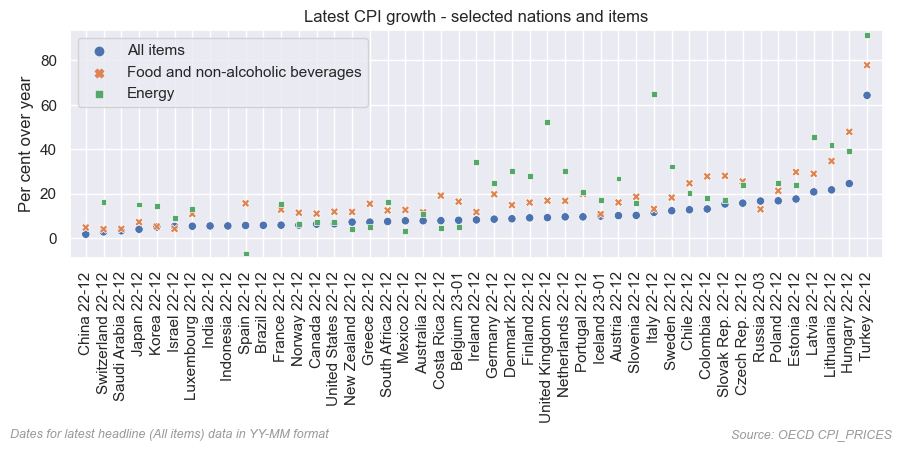

In [30]:
# ... and plot
sns.set(font_scale=1)
ax = sns.scatterplot(frame)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels, rotation=90, )
ax.legend(loc='upper left')

finalise_plot(
    ax, 
    'Latest CPI growth - selected nations and items', 
    'Per cent over year', 
    '', CHART_DIR,
    rfooter=f'{SOURCE} CPI_PRICES',
    lfooter='Dates for latest headline (All items) data in YY-MM format',
    show=True,
)

# tidy-up
plt.style.use('fivethirtyeight')

## Real interest rates

### Get Bank for International Settlements (BIS) Data

In [31]:
bis_meta, bis_data = get_bis_cbpr()

### Notional real interest rates

In [32]:
euro_zone = {'Austria', 'Belgium', 'Croatia', 'Cyprus',
             'Estonia', 'Finland', 'France', 'Germany',
             'Greece', 'Ireland', 'Italy', 'Latvia', 
             'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
             'Portugal', 'Slovakia', 'Slovenia', 'Spain'}

recent = pd.Period('2005-01', freq='M')
inflation_r = inflation[inflation.index >= recent].copy()
inflation_r = inflation_r.rename(columns=location_map)
cb_policy = bis_data.resample(rule='M', kind='period').mean()
cb_policy = cb_policy[cb_policy.index >= recent]

for inf_nation in inflation_r.sort_index(axis=1):
    cbp_nation = inf_nation if inf_nation in cb_policy.columns else None
    if not cbp_nation and inf_nation in euro_zone:
        cbp_nation = "Euro area"
    if not cbp_nation:
        continue
        
    real_rates = cb_policy[cbp_nation] - inflation_r[inf_nation]
    ax = real_rates.plot(lw=2)
    ax.axhline(0, c='#555555', lw=0.5)
    title = f'Notional Real Interest Rates for {inf_nation}'
    finalise_plot(
        ax, title, 
        'Rate (Per cent per year)', 
        '2', CHART_DIR,
        rfooter=f'Source: OECD, BIS',
        lfooter=f'Real Interest Rate = Central Bank Policy Rate - Inflation Rate. '
                'Expansionary policy < 0. Contractionary policy > 0.',
        #show=True,
    )    
    

## Finished

In [33]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Feb 09 2023 12:05:58

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

pandas    : 1.5.3
seaborn   : 0.12.2
matplotlib: 3.6.3

Watermark: 2.3.1



In [34]:
print('Done')

Done
